In [101]:
# import modules/downloads

import pandas as pd
import re
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

import os


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shraeya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
# load test data files

test_set = pd.read_csv("test.txt", sep=";")
train_set = pd.read_csv("train.txt", sep=";")
val_set = pd.read_csv("val.txt", sep=";")
val_set.columns = ["text","sentiment"]
val_set.head()


,text,sentiment
0,i feel like i am still looking at a blank canv...,sadness
1,i feel like a faithful servant,love
2,i am just feeling cranky and blue,anger
3,i can have for a treat or if i am feeling festive,joy
4,i start to feel more appreciative of what god ...,joy


In [103]:
# Data cleaning/preprocessing

# Remove punctuation
val_set['text'] = \
val_set['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Make titles lowercase
val_set['text'] = \
val_set['text'].map(lambda x: x.lower())

# first rows of text
val_set['text'].head()


<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
/var/folders/rd/4d6wd0gx3zjctb1dgrg64fgw0000gn/T/ipykernel_46890/3975563116.py:5: DeprecationWarning: invalid escape sequence \.
  val_set['text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    i feel like i am still looking at a blank canv...
1                       i feel like a faithful servant
2                    i am just feeling cranky and blue
3    i can have for a treat or if i am feeling festive
4    i start to feel more appreciative of what god ...
Name: text, dtype: object

/Users/shraeya/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/shraeya/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/shraeya/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:513: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/shraeya/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/shrae

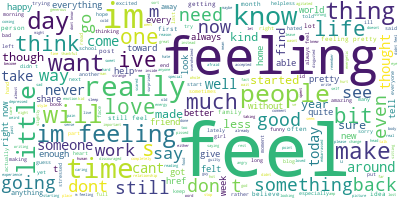

In [104]:
# visual wordcloud exploratory analysis

# Join processed titles
joined_titles = ','.join(list(val_set['text'].values))

# WordCloud object
word_cloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# show word cloud
word_cloud.generate(joined_titles)
word_cloud.to_image()


In [105]:
#transform text data to useful training LDA model input

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'feel', 'feeling', 'really'])

def tokenize_text(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # remove punctuations
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = val_set.text.values.tolist()
tokenized_words = list(tokenize_text(data))

tokenized_words = remove_stopwords(tokenized_words)
print(tokenized_words[:1][0][:10])


['like', 'still', 'looking', 'blank', 'canvas', 'blank', 'pieces', 'paper']


In [106]:
# convert tokenized object into a corpus and dictionary

# Dictionary
id2word = corpora.Dictionary(tokenized_words)
# Corpus
texts = tokenized_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:10])


[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [107]:
# build model with 6 topics (main emotions)

# number of topics
num_topics = 6

lda_mod = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print Keyword in topics
pprint(lda_mod.print_topics())
doc_lda = lda_mod[corpus]


[(0,
  '0.015*"like" + 0.012*"im" + 0.009*"know" + 0.006*"bit" + 0.006*"day" + '
  '0.005*"get" + 0.005*"ive" + 0.005*"always" + 0.005*"much" + 0.005*"way"'),
 (1,
  '0.021*"like" + 0.014*"know" + 0.014*"im" + 0.007*"little" + 0.006*"love" + '
  '0.006*"get" + 0.006*"bit" + 0.006*"time" + 0.005*"people" + 0.004*"feels"'),
 (2,
  '0.015*"im" + 0.007*"would" + 0.006*"time" + 0.005*"people" + 0.005*"though" '
  '+ 0.005*"one" + 0.004*"come" + 0.004*"like" + 0.004*"around" + '
  '0.004*"even"'),
 (3,
  '0.020*"like" + 0.010*"im" + 0.007*"dont" + 0.006*"get" + 0.006*"little" + '
  '0.005*"less" + 0.004*"would" + 0.004*"still" + 0.004*"even" + 0.004*"time"'),
 (4,
  '0.018*"im" + 0.012*"like" + 0.008*"want" + 0.008*"still" + 0.007*"time" + '
  '0.006*"someone" + 0.006*"going" + 0.005*"little" + 0.005*"back" + '
  '0.005*"made"'),
 (5,
  '0.022*"like" + 0.021*"im" + 0.008*"things" + 0.006*"little" + 0.005*"ive" + '
  '0.005*"people" + 0.005*"want" + 0.005*"time" + 0.005*"would" + '
  '0.004*"

In [108]:
# Visualize the topics
cwd = os.getcwd()
directory = os.path.join(cwd, 'results/lda_vis_'+str(num_topics))
if not os.path.exists(directory):
    os.makedirs(directory)

pyLDAvis.enable_notebook()
LDAvis_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

if 1 == 1:
    LDA_vis = pyLDAvis.gensim_models.prepare(lda_mod, corpus, id2word)
    with open(LDAvis_filepath, 'wb') as f:
        pickle.dump(LDA_vis, f)

# load pyLDAvis data from disk
with open(LDAvis_filepath, 'rb') as f:
    LDA_vis = pickle.load(f)
pyLDAvis.save_html(LDA_vis, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDA_vis

/Users/shraeya/Library/Python/3.8/lib/python/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.050667 -0.029044       1        1  19.942597
1      0.039371 -0.035052       2        1  19.191738
4      0.012944 -0.041482       3        1  18.607196
0      0.013894  0.105703       4        1  15.760616
2     -0.120624 -0.015441       5        1  13.303724
3      0.003749  0.015315       6        1  13.194129, topic_info=        Term        Freq       Total Category  logprob  loglift
2       like  262.000000  262.000000  Default  30.0000  30.0000
79      know   98.000000   98.000000  Default  29.0000  29.0000
455     dont   44.000000   44.000000  Default  28.0000  28.0000
17      able   19.000000   19.000000  Default  27.0000  27.0000
237  someone   30.000000   30.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
233      ive    6.083088   50.165359   Topic6  -5.8627  -0.0844
331   always    5.470286   36.595275   Topic6  -5.9688   0.1248
79      know    6.909292   98.672681   Topic6  -5.7353  -0.6335
182     good    5.440647   41.332731   Topic6  -5.9743  -0.0024
708    think    5.063338   50.058434   Topic6  -6.0461  -0.2658

[487 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
17        2  0.153376          able
17        3  0.664631          able
17        5  0.051125          able
17        6  0.051125          able
1981      1  0.834775  accomplished
...     ...       ...           ...
35        3  0.258077           yet
35        4  0.193558           yet
35        6  0.258077           yet
757       1  0.750999         youve
757       2  0.250333         youve

[1029 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 1, 3, 4])